In [33]:
import pandas as pd
import dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import psycopg2

In [34]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

dotenv.load_dotenv()
# Configuração da conexão
config = {
    "host":     os.getenv("host_gcp"),
    "dbname":   "espantalhopneus",
    "user":     os.getenv("meuUser"),
    "password": os.getenv("minhaSenha"),
    "port":     os.getenv("port_gcp")
}

try:
    # Conectar ao banco e criar cursor
    conn = psycopg2.connect(**config)
    cursor = conn.cursor()
    print("Conectado!")

    cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';")
    tables = cursor.fetchall()
    print(tables)

    #Executar a query na tabela vendas
    query = "SELECT * FROM vendas;"
    cursor.execute(query)
    # Obter todas as linhas retornadas
    linhas = cursor.fetchall()
    # Obter os nomes das colunas a partir do cursor.description
    colunas = [desc[0] for desc in cursor.description]
    # Criar o DataFrame com os dados e as colunas
    df_vendas = pd.DataFrame(linhas, columns=colunas)

    query = "SELECT * FROM clientes;"
    cursor.execute(query)
    linhas = cursor.fetchall()
    colunas = [desc[0] for desc in cursor.description]
    df_clientes = pd.DataFrame(linhas, columns=colunas)

    query = "SELECT * FROM clientespessoafisica;"
    cursor.execute(query)
    linhas = cursor.fetchall()
    colunas = [desc[0] for desc in cursor.description]
    df_clientes_PF = pd.DataFrame(linhas, columns=colunas)
    
    #Exibir as primeiras linhas do DataFrame vendas e clientes
    print("TABLE Vendas")
    print(df_vendas.head())
    
    print("TABLE Clientes")
    print(df_clientes.head())

    print("TABLE Clientes")
    print(df_clientes_PF.head())
    
    # Fechar cursor e conexão
    cursor.close()
    conn.close()
    print("fechando cursor e conn")
except Exception as e:
    print(f"Erro ao conectar ou executar a query: {e}")

Conectado!
[('fornecedores',), ('clientes',), ('clientespessoafisica',), ('clientespessoajuridica',), ('familias',), ('produtos',), ('grupos',), ('linhas',), ('marcas',), ('vendaitens',), ('vendas',), ('lojasfisicas',)]
TABLE Vendas
   id_venda  id_cliente  id_loja  data_venda total_venda total_custo  \
0    610621           8        3  2018-04-01       20.00        0.00   
1    620575        8680        1  2018-04-01      560.00      395.56   
2    620576        8680        1  2018-04-01      140.00        0.00   
3    620579       10717        1  2018-04-01     3380.00     2198.24   
4    620580       10717        1  2018-04-01      280.00        0.00   

      forma_pagamento status desconto_total  
0        1 - DINHEIRO  Venda           0.00  
1        1 - DINHEIRO  Venda           0.00  
2        1 - DINHEIRO  Venda           0.00  
3  3 - CARTÃO CREDITO  Venda           0.00  
4  3 - CARTÃO CREDITO  Venda           0.00  
TABLE Clientes
   id_cliente tipo_cliente                 

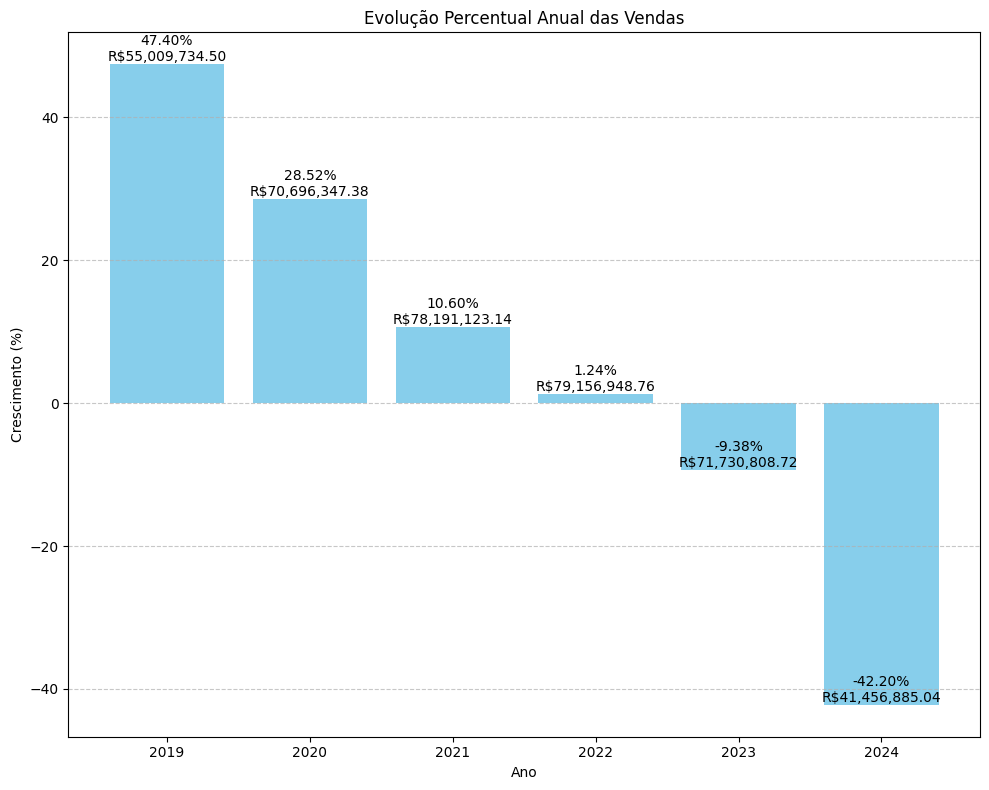

In [35]:
df_vendas = df_vendas[df_vendas['status'] == 'Venda']
df_vendas['data_venda'] = pd.to_datetime(df_vendas['data_venda'])
df_vendas['total_venda'] = pd.to_numeric(df_vendas['total_venda'], errors='coerce')
df_vendas = df_vendas.merge(df_clientes[['id_cliente', 'tipo_cliente']], on='id_cliente', how='left')
df_vendas = df_vendas[df_vendas['tipo_cliente'] == 'F']

# Criar a coluna Ano

df_vendas['Ano'] = df_vendas['data_venda'].dt.year

# Agregar os dados por Ano, somando o total de vendas
df_anual = df_vendas.groupby('Ano')['total_venda'].sum().reset_index()

# Calcular a evolução percentual anual (variação de um ano para o outro)
df_anual['Evolucao (%)'] = df_anual['total_venda'].pct_change() * 100

# Renomear a coluna total_venda para total_item para compatibilidade com o dashboard
df_anual.rename(columns={'total_venda': 'total_item'}, inplace=True)

# Exportar os dados para um arquivo Excel
df_anual.to_excel('faturamento_anual.xlsx', index=False)

# Plotar o gráfico de evolução percentual anual com labels
plt.figure(figsize=(10,8))
bars = plt.bar(df_anual['Ano'].astype(str), df_anual['Evolucao (%)'], color='skyblue')
plt.title('Evolução Percentual Anual das Vendas')
plt.xlabel('Ano')
plt.ylabel('Crescimento (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar os labels com a porcentagem e o valor faturado em cada barra
for bar, perc, tot in zip(bars, df_anual['Evolucao (%)'], df_anual['total_item']):
    height = bar.get_height()
    # Cria uma label com duas linhas: a primeira para a porcentagem e a segunda para o faturamento
    label = f'{perc:.2f}%\nR${tot:,.2f}'
    plt.text(bar.get_x() + bar.get_width()/2, height, label, ha='center', va='bottom')

plt.tight_layout()
plt.show()

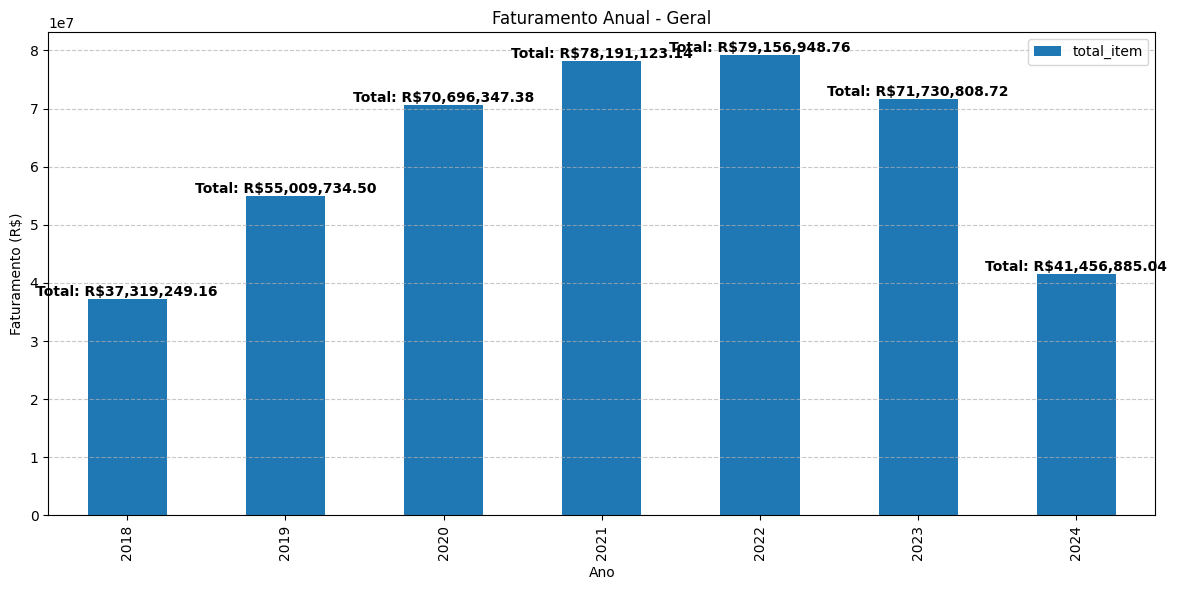

In [36]:
# --- Gráfico Geral: Faturamento Anual ---

df_ano = df_vendas.groupby('Ano')['total_venda'].sum().reset_index()
df_ano.columns = ['Ano', 'total_item']
# Exportar os dados para um arquivo Excel
df_ano.to_excel('faturamento_anual_geral.xlsx', index=False)

# Plotar o gráfico de barras
ax = df_ano.plot(x='Ano', y='total_item', kind='bar', figsize=(12,6), color='#1f77b4')
plt.title('Faturamento Anual - Geral')
plt.xlabel('Ano')
plt.ylabel('Faturamento (R$)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Adicionar label com o valor total no topo de cada barra
for i, row in enumerate(df_ano.itertuples()):
    ax.text(i, row.total_item, f'Total: R${row.total_item:,.2f}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

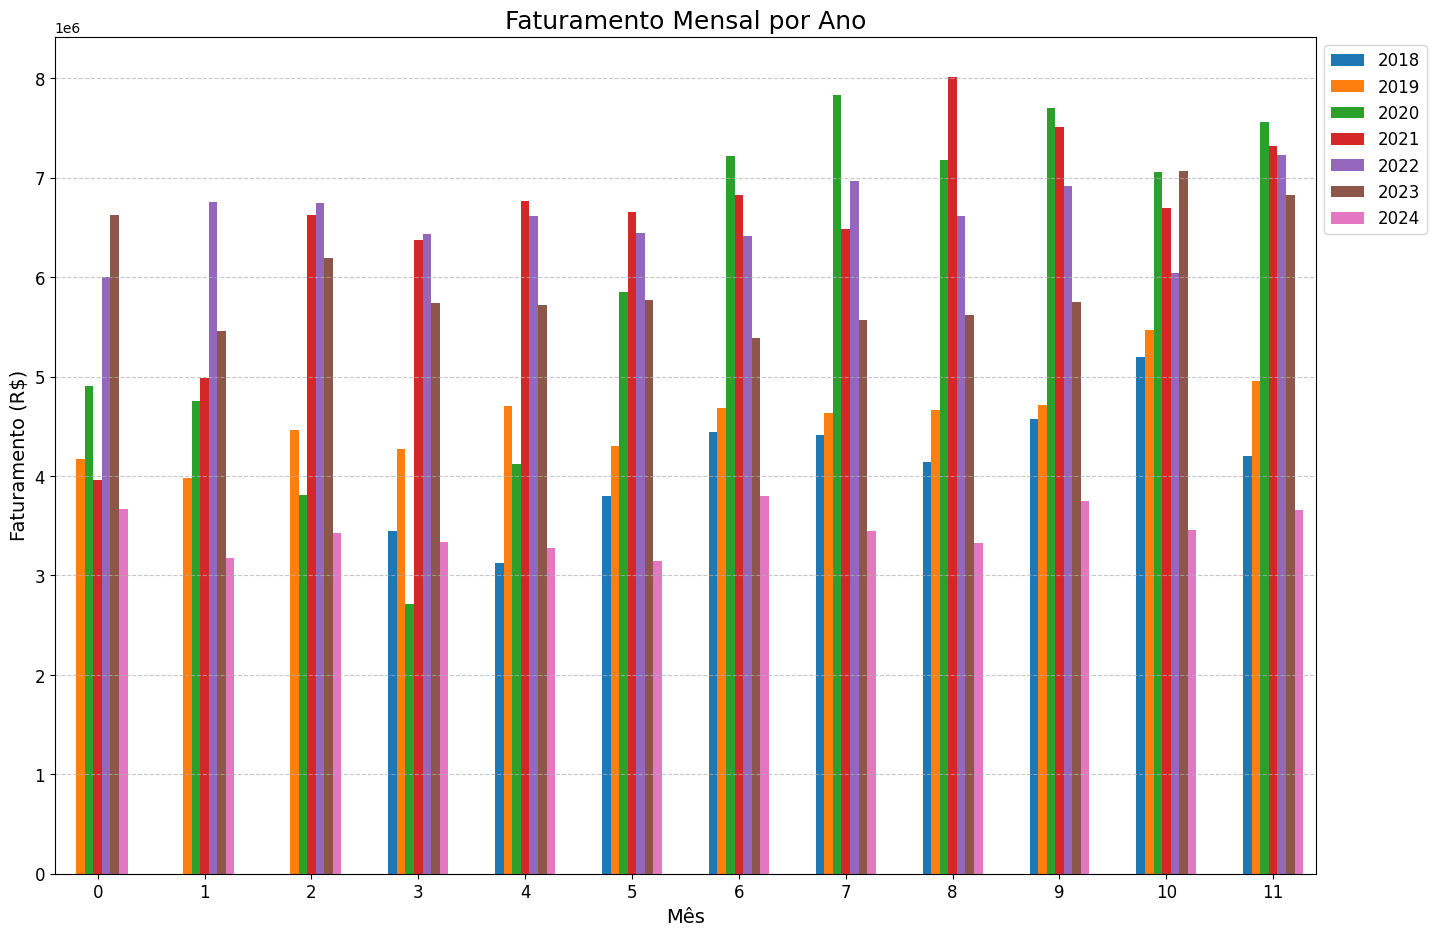

In [37]:
df_vendas['Mês'] = df_vendas['data_venda'].dt.month
# Agrupar por Ano e Mês somando o total_item
df_pivot = df_vendas.groupby(['Ano', 'Mês'])['total_venda'].sum().reset_index()
df_pivot = df_pivot.pivot(index='Mês', columns='Ano', values='total_venda')
df_pivot.reset_index(inplace=True)
df_pivot.to_excel('faturamento_mensal.xlsx', index=False)

anos = [2018, 2019, 2020, 2021, 2022, 2023, 2024] 
fig, ax = plt.subplots(figsize=(15, 10))
width = 0.12
x = np.arange(len(df_pivot.index))
num_anos = len(anos)

x = x * 1.5

# Plotar as barras para cada ano com deslocamentos para que fiquem lado a lado
for i, ano in enumerate(anos):
    valores = df_pivot[ano].fillna(0)
    ax.bar(x + i * width, valores, width=width, label=str(ano))

# Configurar os rótulos do eixo x para que fiquem centralizados
ax.set_xticks(x + width * (num_anos - 1) / 2)
ax.set_xticklabels(df_pivot.index)

# Aumentar o tamanho das fontes
ax.set_title('Faturamento Mensal por Ano', fontsize=18)
ax.set_xlabel('Mês', fontsize=14)
ax.set_ylabel('Faturamento (R$)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# Posicionar a legenda fora do gráfico para mais espaço
ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# Adicionar grade horizontal para facilitar a leitura
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Aumentar o espaçamento entre o gráfico e os elementos
plt.tight_layout(pad=3.0)

# Ajustar os limites do eixo x para ter mais espaço nas bordas
plt.xlim(min(x) - width * 2, max(x) + width * (num_anos + 1))

plt.show()